# MuseGAN Training

## imports

In [9]:
import os
import matplotlib.pyplot as plt
import numpy as np
import types

from musegan import MuseGAN

from music21 import midi
from music21 import note, stream, duration

In [10]:
# run params
SECTION = 'compose'
RUN_ID = '001'



BATCH_SIZE = 64
n_bars = 2
n_steps_per_bar = 16
n_pitches = 84
n_tracks = 4


## data

In [11]:
# Load the data
file = os.path.join("/app/data/bach-chorales/Jsb16thSeparated.npz")
with np.load(file, encoding="bytes", allow_pickle=True) as f:
    data = f["train"]

In [12]:
data_ints = []

for x in data:
    counter = 0
    cont = True
    while cont:
        if not np.any(np.isnan(x[counter : (counter + 4)])):
            cont = False
        else:
            counter += 4

    if n_bars * n_steps_per_bar < x.shape[0]:
        data_ints.append(x[counter : (counter + (n_bars * n_steps_per_bar)), :])

data_ints = np.array(data_ints)

n_songs = data_ints.shape[0]
n_tracks = data_ints.shape[2]

data_ints = data_ints.reshape([n_songs, n_bars, n_steps_per_bar, n_tracks])

max_note = 83

where_are_NaNs = np.isnan(data_ints)
data_ints[where_are_NaNs] = max_note + 1
max_note = max_note + 1

data_ints = data_ints.astype(int)

num_classes = max_note + 1

data_binary = np.eye(num_classes)[data_ints]
data_binary[data_binary == 0] = -1
data_binary = np.delete(data_binary, max_note, -1)

data_binary = data_binary.transpose([0, 1, 2, 4, 3])


In [13]:
data_binary.shape

(229, 2, 16, 84, 4)

## architecture

In [14]:
gan = MuseGAN(input_dim = data_binary.shape[1:]
        , critic_learning_rate = 0.001
        , generator_learning_rate = 0.001
        , optimiser = 'adam'
        , grad_weight = 10
        , z_dim = 32
        , batch_size = BATCH_SIZE
        , n_tracks = n_tracks
        , n_bars = n_bars
        , n_steps_per_bar = n_steps_per_bar
        , n_pitches = n_pitches
        )

In [17]:
gan.chords_tempNetwork.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 temporal_input (InputLayer)  [(None, 32)]             0         
                                                                 
 reshape_18 (Reshape)        (None, 1, 1, 32)          0         
                                                                 
 conv2d_transpose_30 (Conv2D  (None, 2, 1, 1024)       66560     
 Transpose)                                                      
                                                                 
 batch_normalization_30 (Bat  (None, 2, 1, 1024)       4096      
 chNormalization)                                                
                                                                 
 activation_30 (Activation)  (None, 2, 1, 1024)        0         
                                                                 
 conv2d_transpose_31 (Conv2D  (None, 2, 1, 32)         328

In [18]:
gan.barGen[0].summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bar_generator_input (InputL  [(None, 128)]            0         
 ayer)                                                           
                                                                 
 dense_8 (Dense)             (None, 1024)              132096    
                                                                 
 batch_normalization_40 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 activation_40 (Activation)  (None, 1024)              0         
                                                                 
 reshape_28 (Reshape)        (None, 2, 1, 512)         0         
                                                                 
 conv2d_transpose_40 (Conv2D  (None, 4, 1, 512)        524

In [19]:
gan.generator.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 melody_input (InputLayer)      [(None, 4, 32)]      0           []                               
                                                                                                  
 chords_input (InputLayer)      [(None, 32)]         0           []                               
                                                                                                  
 lambda_21 (Lambda)             (None, 32)           0           ['melody_input[0][0]']           
                                                                                                  
 lambda_22 (Lambda)             (None, 32)           0           ['melody_input[0][0]']           
                                                                                           

In [20]:
gan.critic.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 critic_input (InputLayer)   [(None, 2, 16, 84, 4)]    0         
                                                                 
 conv3d_8 (Conv3D)           multiple                  1152      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   multiple                  0         
                                                                 
 conv3d_9 (Conv3D)           multiple                  16512     
                                                                 
 leaky_re_lu_10 (LeakyReLU)  multiple                  0         
                                                                 
 conv3d_10 (Conv3D)          multiple                  196736    
                                                                 
 leaky_re_lu_11 (LeakyReLU)  multiple                  0  

## training

In [21]:

EPOCHS = 6000
PRINT_EVERY_N_BATCHES = 10

gan.epoch = 0

In [24]:
gan.train(     
    data_binary
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = './output/'
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
)

2022-11-07 15:41:05.135471: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0 (5, 1) [D loss: (9.4)(R -0.5, F -0.0, G 1.0)] [G loss: -0.2]


/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


FileNotFoundError: [Errno 2] No such file or directory: './output/images/sample_0.npy'

/tmp/ipykernel_18/1825600972.py:11: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  plt.xlim(0, len(gan.d_losses))


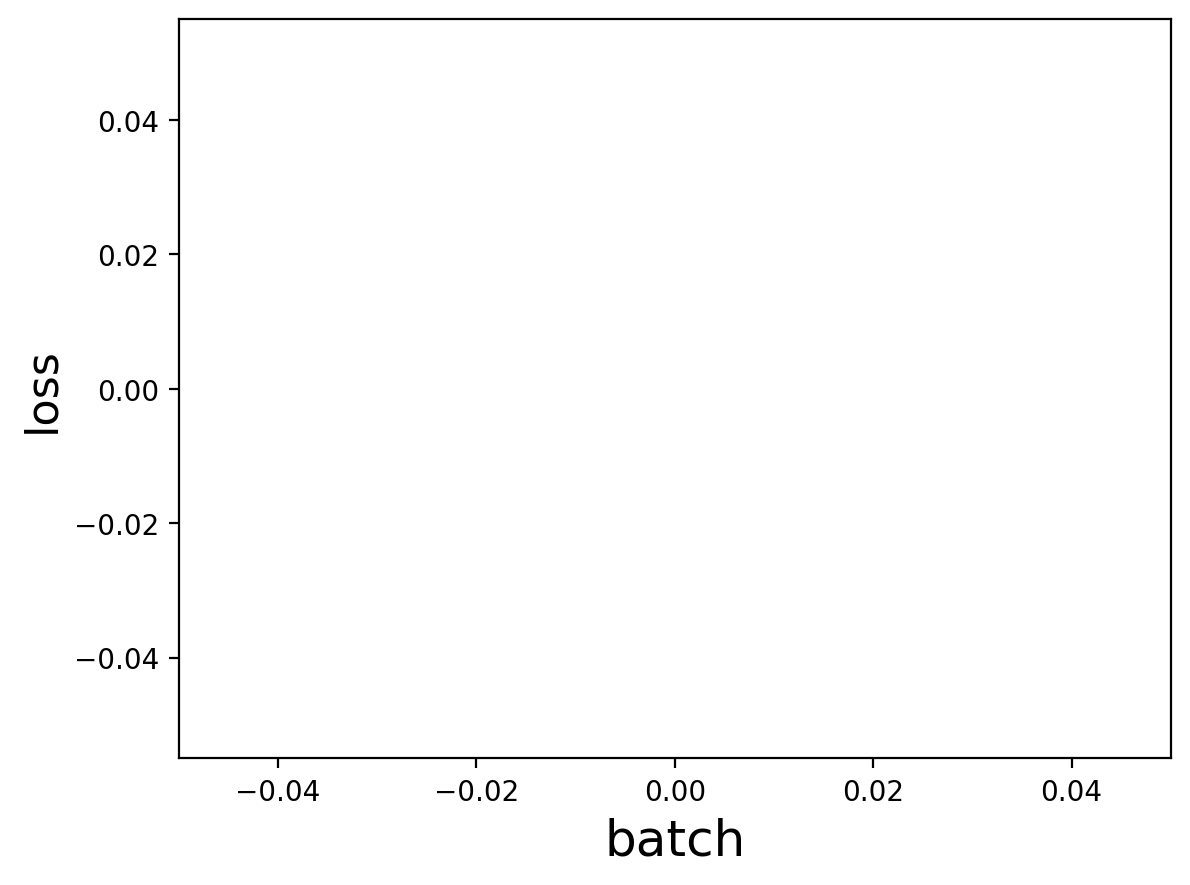

In [23]:
fig = plt.figure()
plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot(gan.g_losses, color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.xlim(0, len(gan.d_losses))
# plt.ylim(0, 2)

plt.show()
